### Imports 👽

In [16]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_classes.enums import Scenario, SamplingMethod

### Prepare Data to Compare ⚙️

In [17]:
scenario = Scenario.SUM_SINES

output_dir = os.path.abspath(os.path.join('..', 'data', scenario.value, 'output'))

sampling_types = [SamplingMethod.SOBOL, SamplingMethod.MC]
epochs_types = [100]

dfs = []
for sampling_type in sampling_types:
    for epochs in epochs_types:
        df = pd.read_csv(os.path.join(output_dir, f'{sampling_type.value}_{epochs}epochs_results.csv'))
        df['epochs'] = epochs
        df['sampling_type'] = sampling_type.value
        dfs.append(df)

together_df = pd.concat(dfs, ignore_index=True)
together_df.to_csv(os.path.join(output_dir, 'together.csv'), index=False)

### Analysis 📊

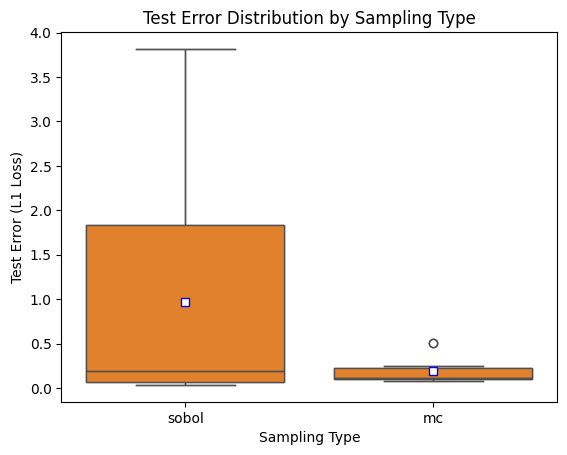

In [18]:
sns.boxplot(data=together_df, x="sampling_type", y="test_error")
sns.boxplot(data=together_df, x="sampling_type", y="test_error", showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})

plt.title("Test Error Distribution by Sampling Type")
plt.ylabel("Test Error (L1 Loss)")
plt.xlabel("Sampling Type")
plt.show()

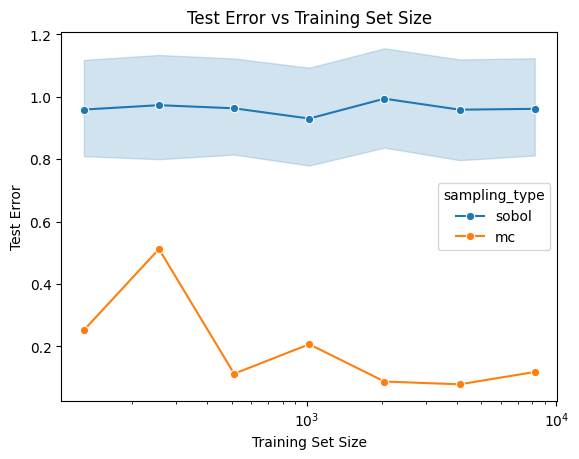

In [19]:
sns.lineplot(
    data=together_df,
    x="train_size",
    y="test_error",
    hue="sampling_type",
    marker="o"
)
plt.title("Test Error vs Training Set Size")
plt.ylabel("Test Error")
plt.xlabel("Training Set Size")
plt.xscale("log")  # if sizes vary exponentially
plt.show()


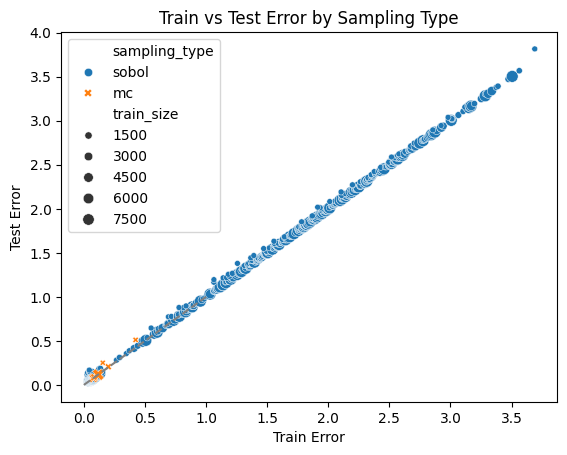

In [20]:
sns.scatterplot(
    data=together_df,
    x="train_error",
    y="test_error",
    hue="sampling_type",
    style="sampling_type",
    size="train_size"
)
plt.title("Train vs Test Error by Sampling Type")
plt.plot([0, 1], [0, 1], ls="--", c="gray")  # identity line
plt.xlabel("Train Error")
plt.ylabel("Test Error")
plt.show()


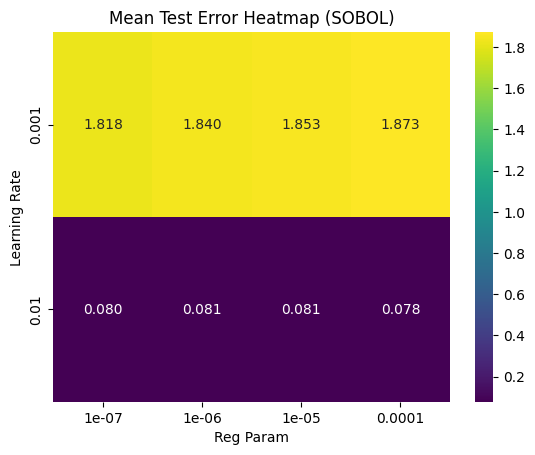

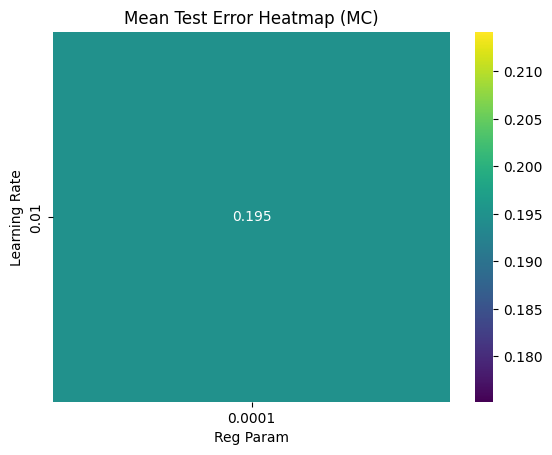

In [21]:
for method in ["sobol", "mc"]:
    pivot = together_df[together_df["sampling_type"] == method].pivot_table(
        index="learning_rate",
        columns="reg_param",
        values="test_error",
        aggfunc="mean"
    )
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Mean Test Error Heatmap ({method.upper()})")
    plt.ylabel("Learning Rate")
    plt.xlabel("Reg Param")
    plt.show()


In [22]:
together_df.loc[(together_df.depth == 4) & (together_df.sampling_type == 'sobol')]

,learning_rate,reg_param,batch_norm,depth,num_hidden_layers,activation,train_error,test_error,train_size,optim_time,epochs,sampling_type


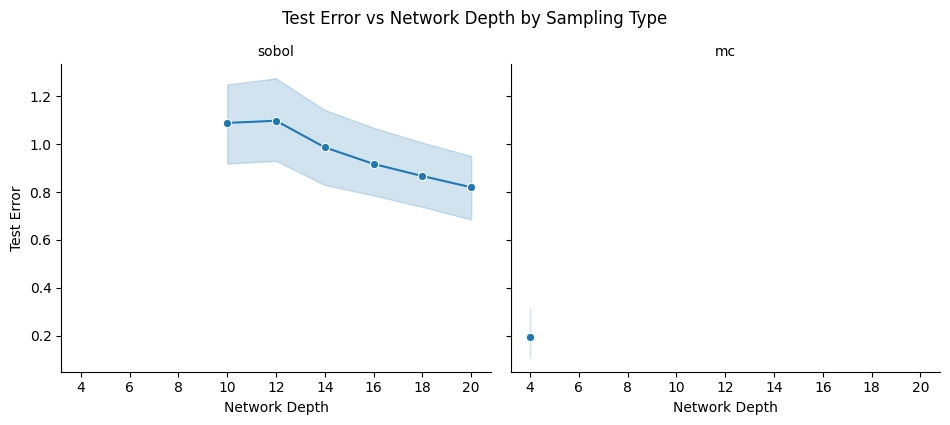

In [23]:
g = sns.FacetGrid(
    together_df, col="sampling_type", height=4, aspect=1.2
)
g.map_dataframe(sns.lineplot, x="depth", y="test_error", marker="o")
g.set_axis_labels("Network Depth", "Test Error")
g.set_titles(col_template="{col_name}")
plt.suptitle("Test Error vs Network Depth by Sampling Type", y=1.05)
plt.show()


In [24]:
model = smf.ols('test_error ~ sampling_type + train_size + reg_param + learning_rate', data=together_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             test_error   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     831.5
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          1.08e-317
Time:                        22:21:26   Log-Likelihood:                -708.33
No. Observations:                1015   AIC:                             1427.
Df Residuals:                    1010   BIC:                             1451.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2